In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import bambi as bmb
import arviz as az
import pymc3 as pm
from matplotlib import pyplot as plt

import candas as can
from candas.utils import molar2copies

from sklearn import linear_model
from scipy.stats import gmean, linregress
import scipy as sp

import pathlib as pl

%config InlineBackend.figure_format ='retina'

code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'

gen_pth = fig_pth / 'generated'
gen_pth.mkdir(exist_ok=True)

plt.style.use(str(can.style.breve))
SEED=2021

# Data wrangling

In [2]:
raw = pd.read_excel(data_pth / 'SQ-24920 Nanostring_ICL-ILMN01_Data.xlsx', sheet_name='Raw data')
normed = pd.read_excel(data_pth / 'SQ-24920 Nanostring_ICL-ILMN01_Data.xlsx', sheet_name='POS-HK gene normalized data')
meta = pd.read_excel(data_pth / 'clinical_metadata_NanoString.xlsx', sheet_name='clin_meta').rename(columns={'sample.id':'Sample'})

has_viral = ~meta.any_viral_path.isna()
has_bac = ~meta.bact_path.isna() & (meta.bact_path!='other_tb')

meta['Viral'] = has_viral
meta['Bacterial'] = has_bac
meta['Diagnosis'] = meta['Viral'].map({True:'Viral', False:'Bacterial'})
has_one = meta[meta['Viral'] ^ meta['Bacterial']]

header = raw.iloc[:13].drop(columns = ['Gene','ID']).dropna()

raw = (raw.iloc[13:]
        .dropna()
        .rename(columns={'File Name': 'Type'})
        .rename(columns={sample: sample[15:-7] for sample in raw.columns if 'ICL' in sample})
        .set_index(['Gene','Type','ID'])
        [has_one['Sample'].values]
        .reset_index()
        .melt(id_vars=['Gene', 'Type', 'ID'], var_name='Sample', value_name='Count')
        .merge(meta[['Sample', 'Viral', 'Bacterial', 'Diagnosis']])
        .astype({'Count':float})
        .assign(lg10_Count = lambda df: np.log10(df.Count))
       )
normed = (normed
        .dropna()
        .rename(columns={'File Name': 'Type'})
        .rename(columns={sample: sample[15:-7] for sample in normed.columns if 'ICL' in sample})
        .set_index(['Gene','Type','ID'])
        [has_one['Sample'].values]
        .reset_index()
        .melt(id_vars=['Gene', 'Type', 'ID'], var_name='Sample', value_name='Count')
        .merge(meta[['Sample', 'Viral', 'Bacterial', 'Diagnosis']])
        .astype({'Count':float})
        .assign(lg10_Count = lambda df: np.log10(df.Count))
       )

pos_ctrl = (raw[raw.Type=='Positive']
            .reset_index(drop=True)
            .drop(columns=['Type','ID'])
           )
neg_ctrl = (raw[raw.Type=='Negative']
            .reset_index(drop=True)
            .drop(columns=['Type','ID'])
           )
hk = (raw[raw.Type=='Housekeeping']
      .reset_index(drop=True)
      .drop(columns=['Type','ID'])
     )
endo = (raw[raw.Type=='Endogenous']
        .drop(columns=['Type','ID'])
        .reset_index(drop=True)
       )

genes = ['EMRI', 'FAM89A', 'IFI44L']

lg_C = endo.set_index(['Sample','Gene'])['lg10_Count'].unstack()
dx = endo.set_index(['Sample'])['Diagnosis']
lg_C = lg_C[genes].merge(dx.reset_index().drop_duplicates(), on='Sample')

In [3]:
meta.any_viral_path.unique()

array([nan, 'RSV', 'Parechovirus', 'Enterovirus', 'Adenovirus', 'EBV',
       'Rhinovirus', 'RSV + RHINOVIRUS', 'RHINOVIRUS', 'ROTAVIRUS'],
      dtype=object)

In [4]:
meta.bact_path.unique()

array([nan, 'Pseudomonas aeruginosa', 'Salmonella', 'Pneumococc',
       'E.coli', 'Kingella', 'GAS', 'S.aureus', 'Coliform', 'Meningo',
       'Pneumococc 27', 'other_tb'], dtype=object)

<Axes: xlabel='Gene', ylabel='lg10_Count'>

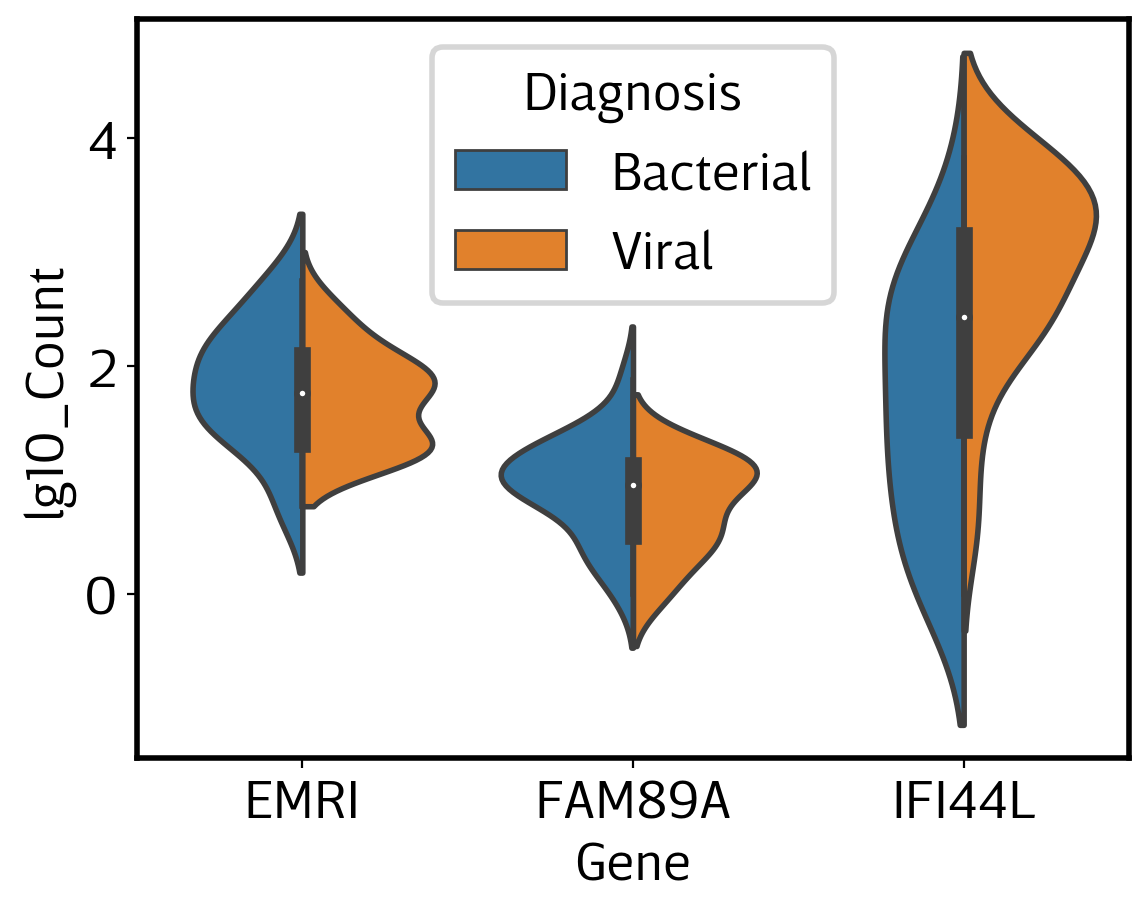

In [5]:
sns.violinplot(data=endo[endo['Gene'].isin(genes)], x='Gene', y='lg10_Count', hue='Diagnosis', split='Diagnosis')

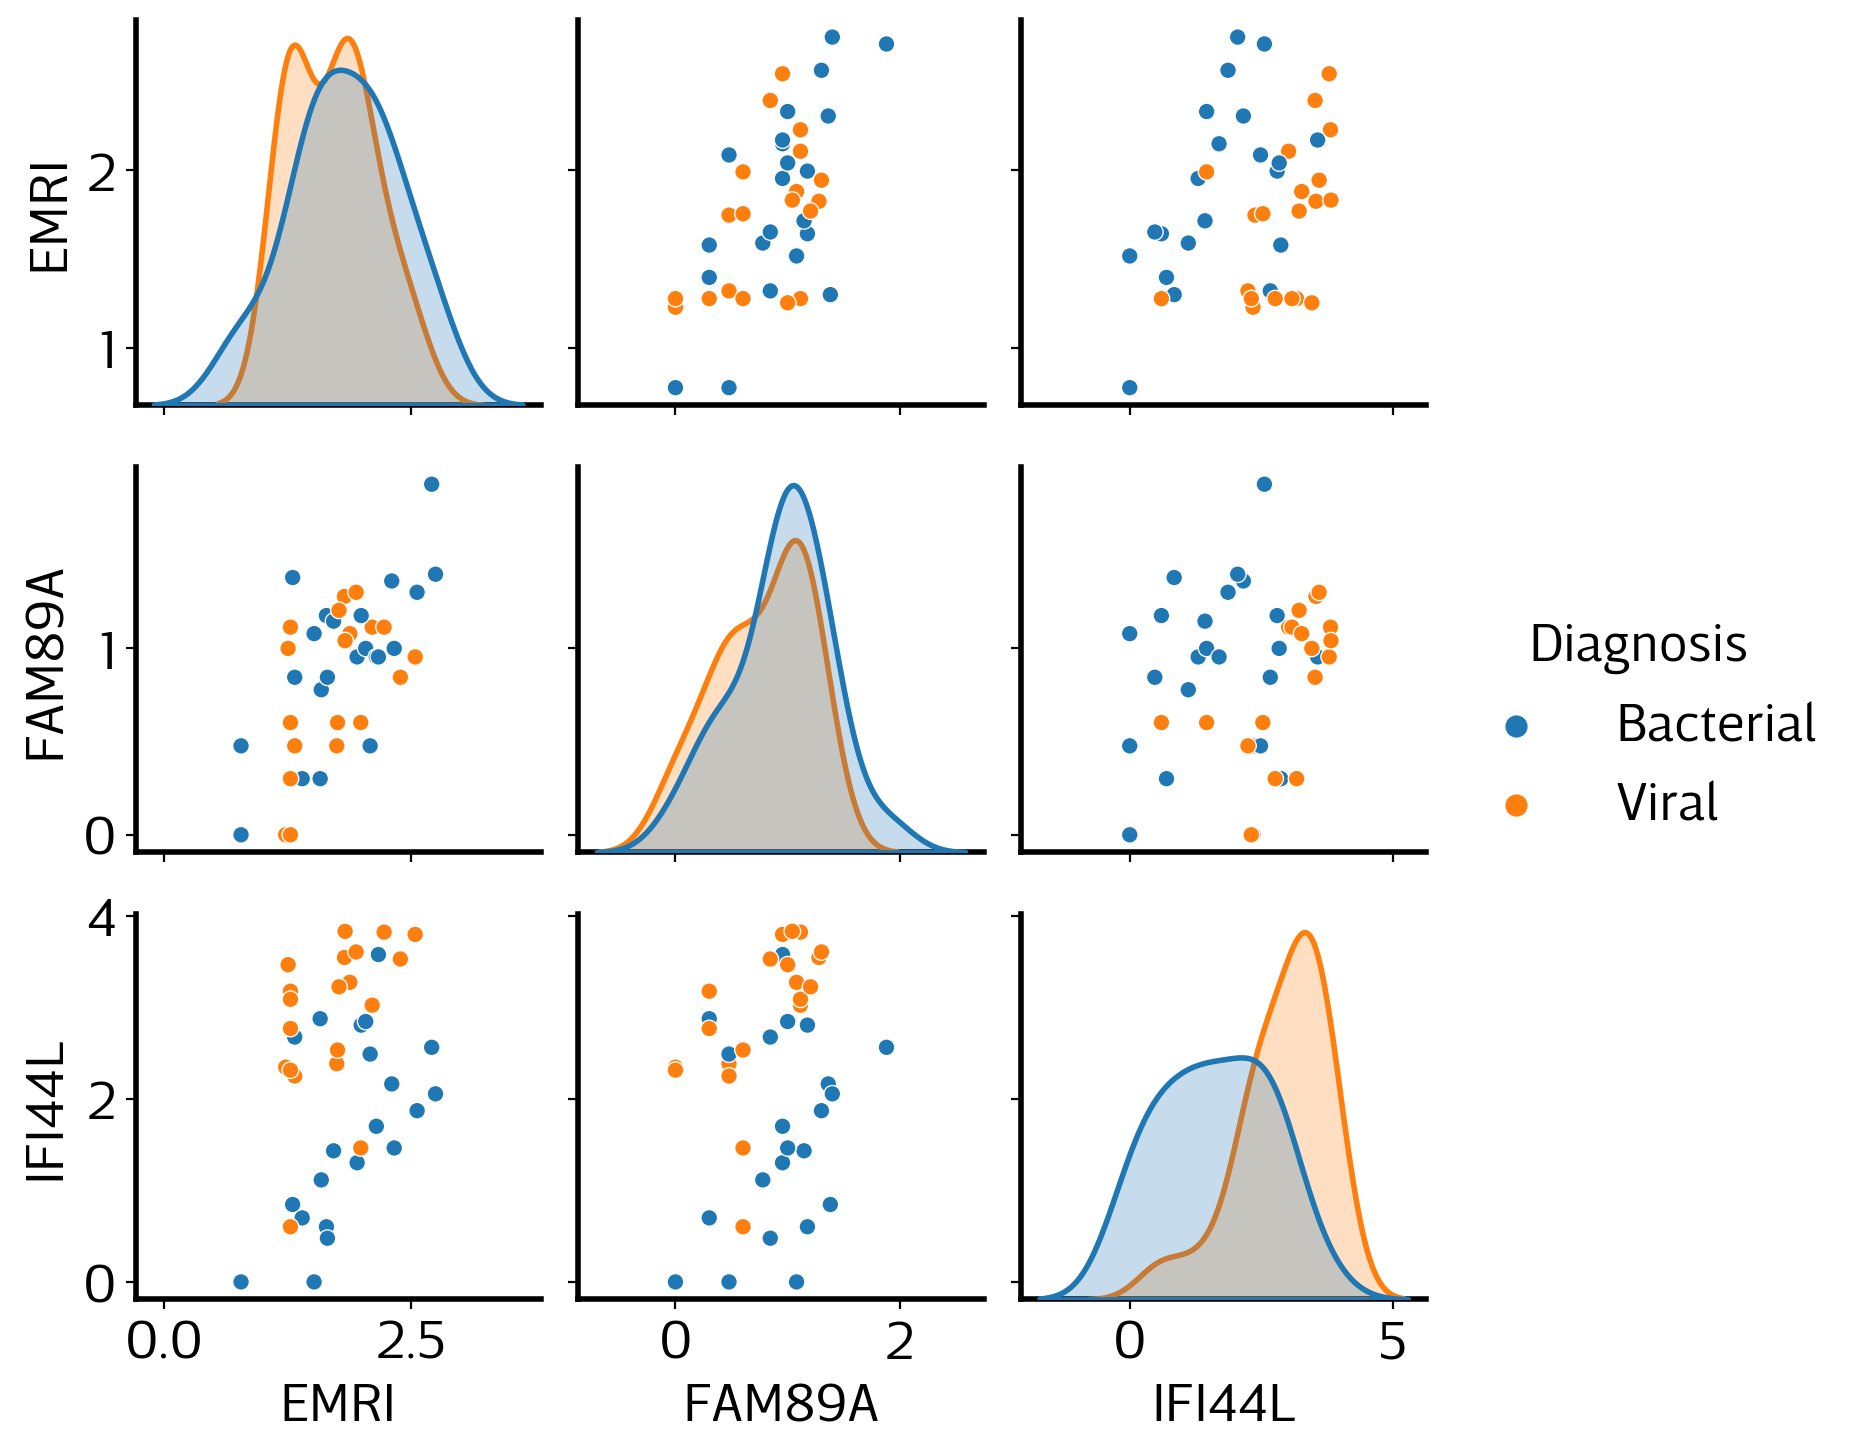

In [6]:
sns.pairplot(lg_C, vars=genes, hue='Diagnosis')

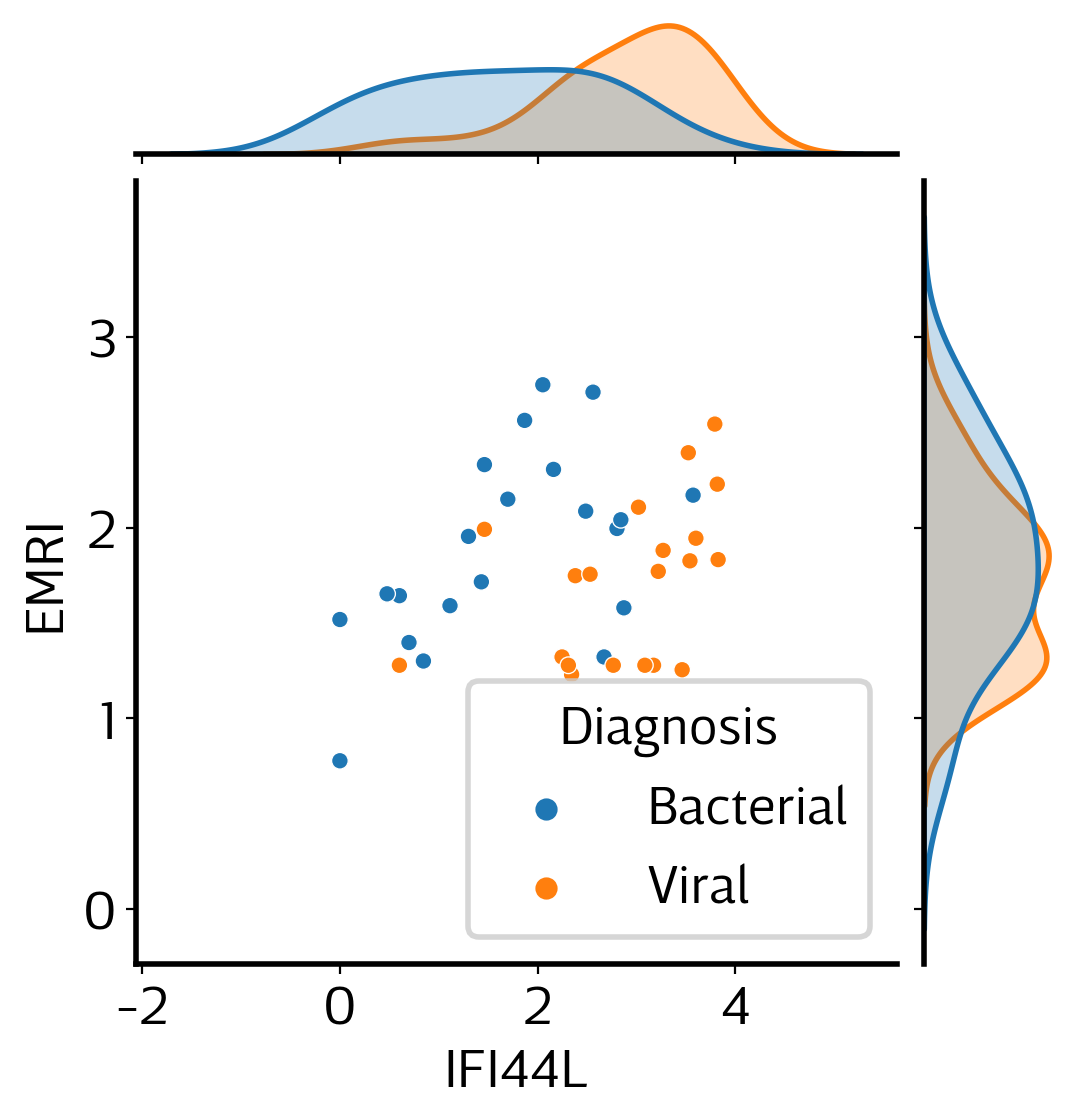

In [7]:
sns.jointplot(data=lg_C, x='IFI44L', y='EMRI', hue='Diagnosis')

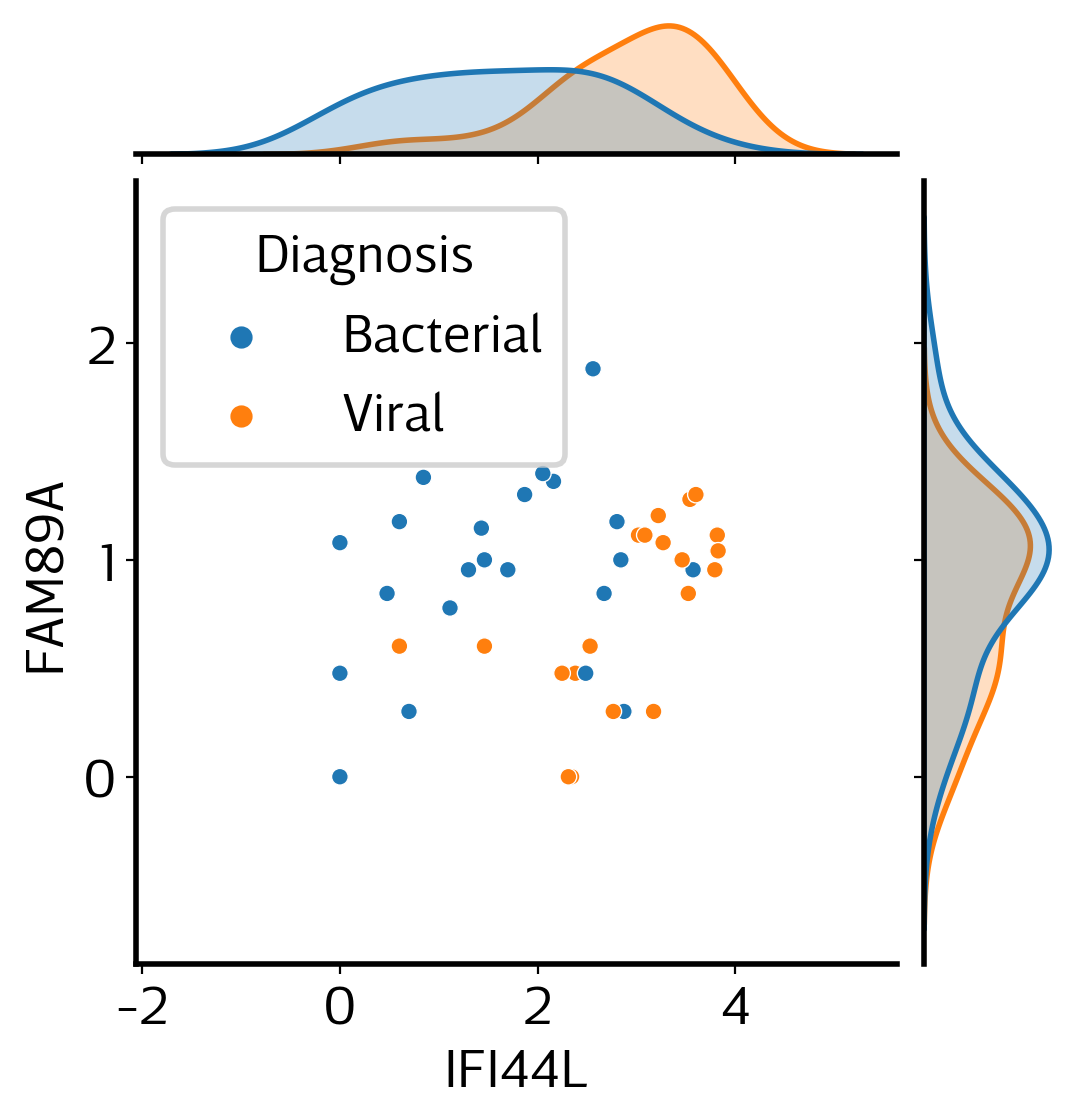

In [8]:
sns.jointplot(data=lg_C, x='IFI44L', y='FAM89A', hue='Diagnosis')

## Calibration and normalization

Each sample is run separately, with positive and negative controls included. Thus, there is some variation in the binding performance of the instrument. According to one version of the __[Nanostring guide](https://www.genetics.pitt.edu/sites/default/files/pdfs/nCounter_Gene_Expression_Data_Analysis_Guidelines.pdf)__, the positive controls (A-F) are present at 128, 32, 8, 2, 0.5, and 0.125 fM, with *POS_F* technically below the detection limit of the machine. A different version of the __[Nanostring guide](https://nanostring.com/wp-content/uploads/Gene_Expression_Data_Analysis_Guidelines.pdf)__ (§ Positive Control Normalization) suggests using these to normalize each run by taking the geometric mean of counts for each positive control in a given run, taking the arithmetic mean of those geomeans across all runs, and then dividing the arithmetic mean by the individual geomean to get the respective normalization factor for that run.

We need to get the _actual_ concentration of each transcript, so we'll do a separate regression for each run. 

### Define positive controls

In [9]:
pos_concs = pd.DataFrame(
    data=np.array([
        ['POS_A', 'POS_B', 'POS_C', 'POS_D', 'POS_E', 'POS_F'],
        [128, 32, 8, 2, 0.5, 0.125]
    ]).T,
    columns=['Gene','fM']
).astype({'fM':float})

In [10]:
aug_pos = (pos_ctrl
 .merge(pos_concs)
 .assign(
     lg10_Count = lambda df: np.log10(df.Count),
     lg10_M = lambda df: np.log10(df.fM)-12,
     lg10_Copies = lambda df: np.log10(molar2copies(df.fM*1e-12, volume=1)),
        )
)

aug_pos

,Gene,Sample,Count,Viral,Bacterial,Diagnosis,lg10_Count,fM,lg10_M,lg10_Copies
0,POS_A,101-1400,48418.0,False,True,Bacterial,4.685007,128.000,-9.89279,7.886951
1,POS_A,101-1525,55197.0,False,True,Bacterial,4.741915,128.000,-9.89279,7.886951
2,POS_A,102-1283,64817.0,False,True,Bacterial,4.811689,128.000,-9.89279,7.886951
3,POS_A,102-1432,35843.0,False,True,Bacterial,4.554404,128.000,-9.89279,7.886951
4,POS_A,103-1078,53535.0,False,True,Bacterial,4.728638,128.000,-9.89279,7.886951
...,...,...,...,...,...,...,...,...,...,...
247,POS_F,GENDRES-9004,65.0,True,False,Viral,1.812913,0.125,-12.90309,4.876651
248,POS_F,GENDRES-9014,59.0,True,False,Viral,1.770852,0.125,-12.90309,4.876651
249,POS_F,GENDRES-PAC21,76.0,True,False,Viral,1.880814,0.125,-12.90309,4.876651
250,POS_F,GENDRES-PAC26,76.0,True,False,Viral,1.880814,0.125,-12.90309,4.876651


### Calibration with uncertainty

In [11]:
class LRPI:
    def __init__(self, normalize=False, n_jobs=1, t_value = 2.13144955):
        self.normalize = normalize
        self.n_jobs = n_jobs
        self.LR = linear_model.LinearRegression(n_jobs= self.n_jobs)
        self.t_value = t_value
        
    def fit(self, X_train, y_train):
        self.X_train = pd.DataFrame(X_train.values)
        self.y_train = pd.DataFrame(y_train.values)
        
        self.LR.fit(self.X_train, self.y_train)
        X_train_fit = self.LR.predict(self.X_train)
        self.MSE = np.power(self.y_train.subtract(X_train_fit), 2).sum(axis=0) / (self.X_train.shape[0] - self.X_train.shape[1] - 1)
        self.X_train.loc[:, 'const_one'] = 1
        self.XTX_inv = np.linalg.inv(np.dot(np.transpose(self.X_train.values) , self.X_train.values))
        
    def predict(self, X_test):
        self.X_test = pd.DataFrame(X_test.values)
        self.pred = self.LR.predict(self.X_test)
        self.X_test.loc[: , 'const_one'] =1
        SE = [np.dot(np.transpose(self.X_test.values[i]) , np.dot(self.XTX_inv, self.X_test.values[i]) ) for i in range(len(self.X_test)) ]
        results = pd.DataFrame(self.pred , columns=['Pred'])
        
        results.loc[:,"lower"] = results['Pred'].subtract((self.t_value)* (np.sqrt(self.MSE.values + np.multiply(SE,self.MSE.values) )),  axis=0)
        results.loc[:,"upper"] = results['Pred'].add((self.t_value)* (np.sqrt(self.MSE.values + np.multiply(SE,self.MSE.values) )),  axis=0)
        
        return results

In [12]:
LRPIs = {s: LRPI() for s, _ in aug_pos.groupby('Sample', group_keys=False)}
for s, df in aug_pos.groupby('Sample', group_keys=False):
    LRPIs[s].fit(df.lg10_Count, df.lg10_Copies)
preds = {s: LRPIs[s].predict(df.lg10_Count) for s, df in endo.groupby('Sample', group_keys=False)}
def get_preds(grp):
    preds = (LRPIs[grp.name]
             .predict(grp.lg10_Count)
             .rename(columns={
                 'Pred':'lg10_Copies', 
                 'lower':'lg10_Copies_l', 
                 'upper':'lg10_Copies_u'
             })
            )
    preds.index = grp.index
    return pd.concat([grp,preds], axis=1)

copies = endo.groupby('Sample', group_keys=False).apply(get_preds).reset_index(drop=True)
neg_preds = neg_ctrl.groupby('Sample', group_keys=False).apply(get_preds).reset_index(drop=True)

copies[copies.Gene.isin(['EMRI','IFI44L'])].set_index('Sample')
dx = endo.set_index(['Sample'])['Diagnosis'].reset_index().drop_duplicates()

lg10_Copies = (copies
               .set_index(['Sample','Gene'])
               ['lg10_Copies']
               .unstack()
               [genes]
               .merge(dx, on='Sample')
              )
lg10_Copies_u = (copies
               .set_index(['Sample','Gene'])
               ['lg10_Copies_u']
               .unstack()
               [genes]
               .merge(dx, on='Sample')
              )
lg10_Copies_l = (copies
               .set_index(['Sample','Gene'])
               ['lg10_Copies_l']
               .unstack()
               [genes]
               .merge(dx, on='Sample')
              )

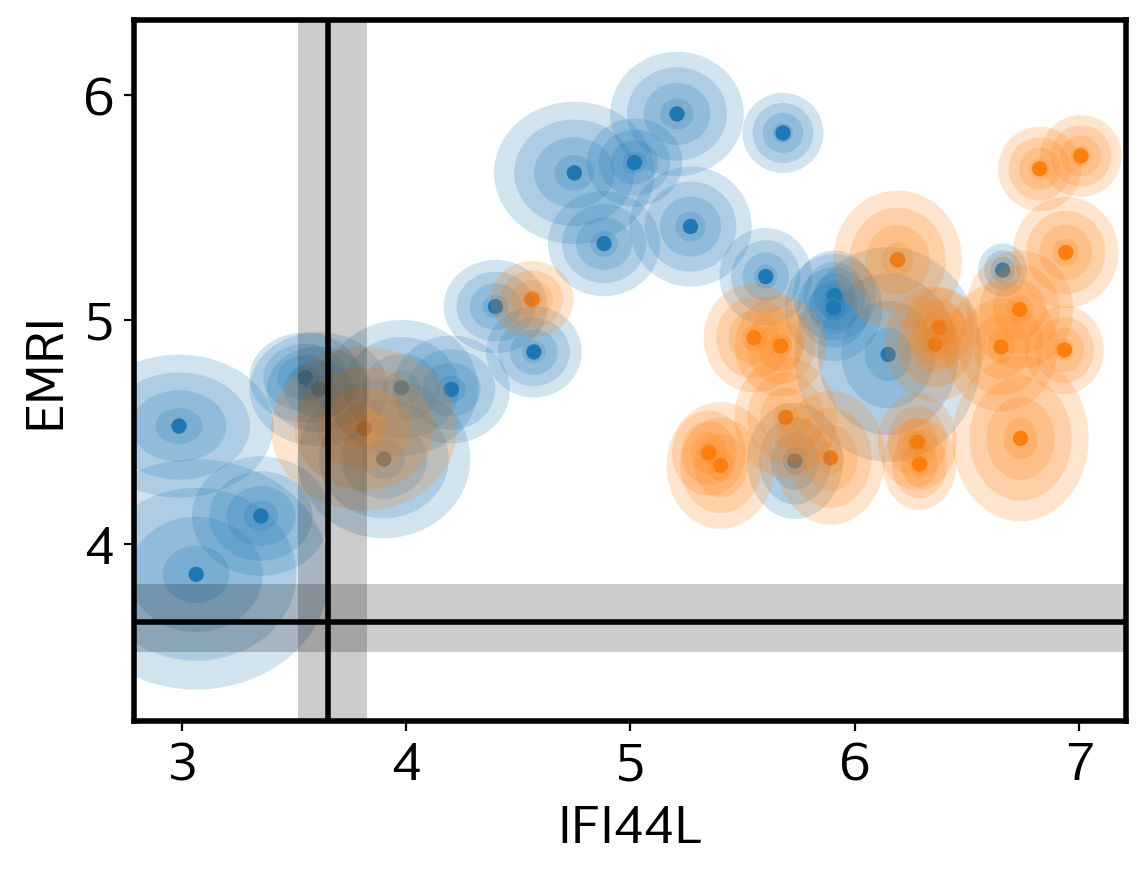

In [13]:
sns.scatterplot(data=lg10_Copies, x='IFI44L', y='EMRI', hue='Diagnosis', legend=False)


from matplotlib.patches import Ellipse, Rectangle

for i, Dx in enumerate(['Bacterial','Viral']):
    l = lg10_Copies_l[lg10_Copies_l.Diagnosis==Dx]
    c = lg10_Copies[lg10_Copies.Diagnosis==Dx]
    u = lg10_Copies_u[lg10_Copies_u.Diagnosis==Dx]
    color = f'C{i}'
    
#     plt.plot(c.IFI44L.values, c.EMRI.values, color=color, ls='None', marker='o')
    ax = plt.gca()
    ax.set_aspect('equal')
    
    for sample in c.Sample.unique():
        for sdm in [1/4, 1/2, 3/4, 1]:
            ellipse = Ellipse(
                xy=(c[c.Sample==sample].IFI44L.values, c[c.Sample==sample].EMRI.values), 
                width=(u[u.Sample==sample].IFI44L-l[l.Sample==sample].IFI44L).values*sdm, 
                height=(u[u.Sample==sample].EMRI-l[l.Sample==sample].EMRI).values*sdm, 
                fc=color, alpha=0.2)
            ax.add_patch(ellipse)
            

neg = neg_preds.lg10_Copies
neg = neg_preds.groupby('Sample')['lg10_Copies'].apply(gmean).describe(percentiles=[0.025,0.50,0.975])
for line in [ax.axvline, ax.axhline]:
    line(neg['50%'], color='k', ls='-')
    
yl = ax.get_ylim()
xl = ax.get_xlim()    

rect = Rectangle(
    xy = (neg['2.5%'], yl[0]),
    height = np.diff(yl)[0],
    width = neg['97.5%']-neg['2.5%'],
    fc='k', alpha=0.2)
ax.add_patch(rect)

rect = Rectangle(
    xy = (xl[0], neg['2.5%']),
    height = neg['97.5%']-neg['2.5%'],
    width = np.diff(xl)[0],
    fc='k', alpha=0.2)
ax.add_patch(rect);

In [14]:
lg10_Copies.to_csv(gen_pth / 'Processed patient data.csv', index=False)

# Logistic Regression

In [15]:
genes = ['IFI44L','EMRI']
means = lg10_Copies[genes].mean(0)
lg10_Copies['Bacterial'] = lg10_Copies.Diagnosis=='Bacterial'
cntrd = lg10_Copies.copy()
cntrd[genes] = cntrd[genes]-means
means

IFI44L    5.371906
EMRI      4.911704
dtype: float64

In [16]:
bmb_model = bmb.Model('Bacterial ~ 0 + ' + ' + '.join(genes), cntrd, family="bernoulli")

In [17]:

coords = {'gene': genes, 'sample': lg10_Copies.Sample}
with pm.Model(coords = coords) as model:
    # Train on filtered patients
    data = pm.Data('data', lg10_Copies[genes].values, dims=('sample','gene'))
    
    means = lg10_Copies[genes].mean(0)
    # Use bambi's auto-scaled priors
    prior_mus = np.zeros(len(genes))
    # prior_sigmas = np.concatenate([prior['sigma'] for prior in bmb_model.scaler.priors.values()])
    prior_sigmas = np.array([prior['sigma'] for prior in bmb_model.scaler.priors.values()])
    
    slopes = pm.Normal('slopes', prior_mus, prior_sigmas, dims='gene')
    
    logit_p = pm.Deterministic('logit_p', pm.math.dot(data-means, slopes))
    p = pm.Deterministic('p', pm.math.invlogit(logit_p))
    _ = pm.Bernoulli('Bacterial', logit_p=logit_p, observed=cntrd.Bacterial.values)
    
    idata = pm.sample(draws=10000, chains=4, return_inferencedata=True, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slopes]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 8 seconds.


## Posterior

In [18]:
slope_names = {f'slopes[{i}]':g for i,g in enumerate(genes)}
summary = az.summary(idata, var_names=['slopes']).rename(slope_names)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slopes[IFI44L],-1.748,0.473,-2.651,-0.894,0.003,0.002,18631.0,21814.0,1.0
slopes[EMRI],2.264,1.058,0.401,4.363,0.008,0.006,18308.0,18361.0,1.0


## Predictions

### Patient diagnoses and confidence

In [19]:
# Test on all patients
with model:
    pm.set_data({"data": lg10_Copies[genes]})
    pps = pm.fast_sample_posterior_predictive(idata, var_names = ['logit_p', 'p', 'Bacterial'], random_seed=SEED)

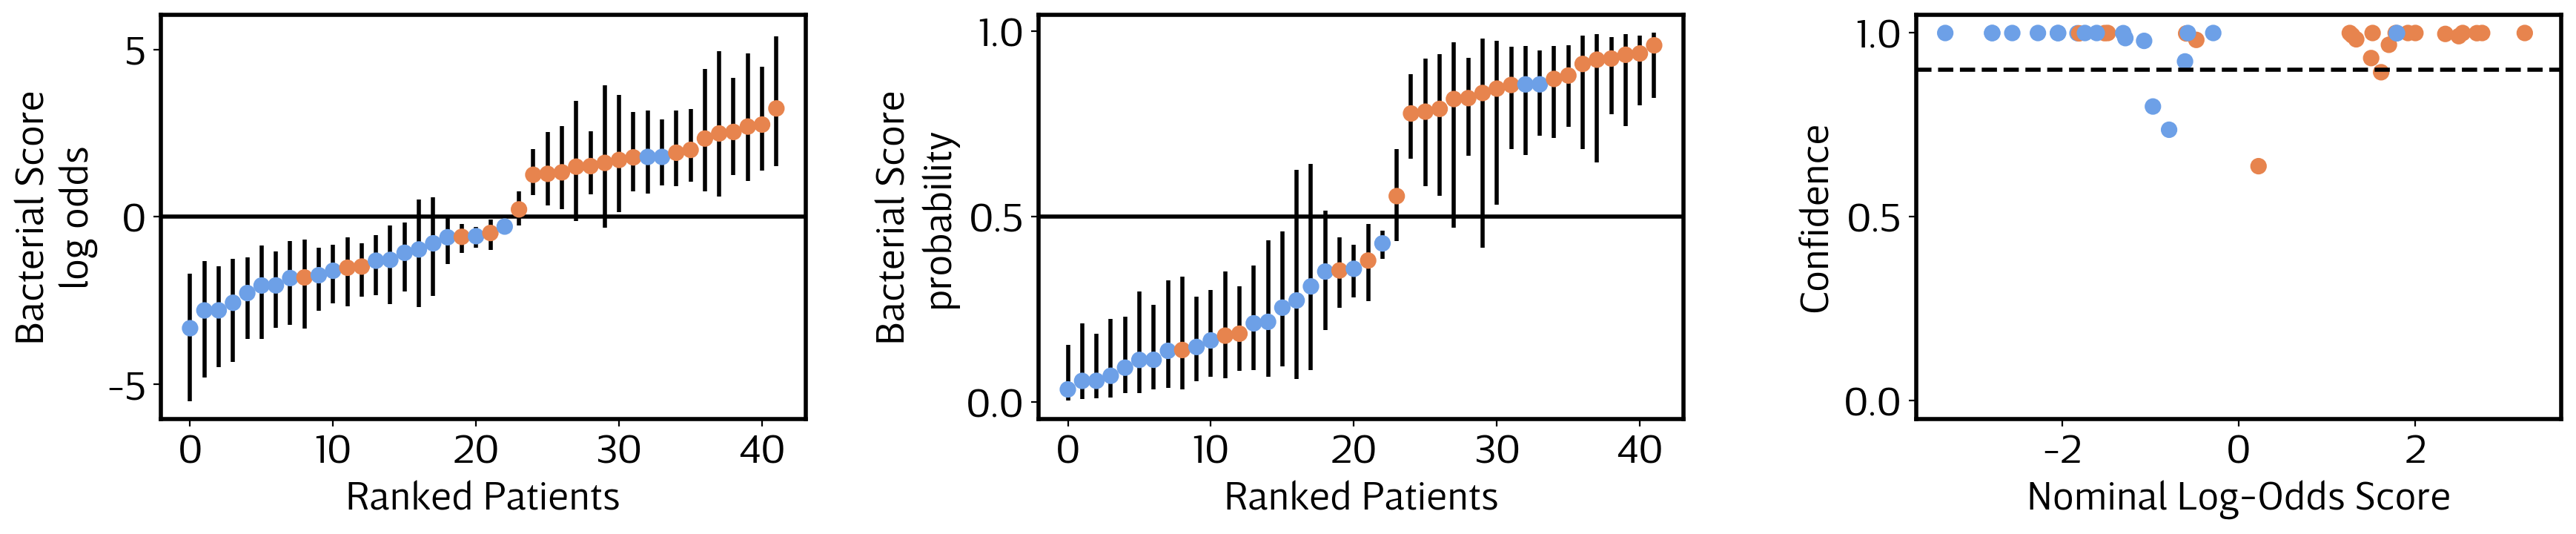

In [20]:
axs = plt.subplots(1,3, figsize=(18,4))[1]
cmap = sns.diverging_palette(220, 20, n=2, as_cmap=True)
cmap = sns.diverging_palette(250, 30, l=65, n=2, as_cmap=True)

outliers = []

for ax, param in zip(axs, ['logit_p','p']):
    
    l,m,u = [np.percentile(pps[param], p, axis=0) for p in [2.5, 50, 97.5]]
    idx = np.argsort(m)
    x = np.arange(len(idx))
    c = lg10_Copies.Bacterial[idx]
    
    threshold = {'logit_p':0, 'p':0.5}[param]
    ax.axhline(threshold, color='k', zorder=-2)
    ax.errorbar(x=x, y=m[idx], yerr=np.row_stack([m-l,u-m])[:,idx], color='k', ls='none', zorder=-1)
    ax.scatter(x=x, y=m[idx], c=c, cmap=cmap)
    
    if len(outliers)>0:
        outlier_rank = [pos for outlier in outliers for pos, idx_ in enumerate(idx)if idx_ == outlier]
        ax.scatter(x=outlier_rank, y=m[outliers], facecolor='w', edgecolor=cmap(0.999*lg10_Copies.loc[outliers,:].Bacterial))
    ylabel = {'logit_p': 'Bacterial Score\nlog odds', 'p': 'Bacterial Score\nprobability'}[param]
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Ranked Patients')
    if param=='logit_p':
        # Symmetrize ylim
        yl = ax.get_ylim()
        ax.set_ylim(np.max(np.abs(yl))*np.array([-1,+1]))
    
ax = axs[2]
score = np.percentile(pps['logit_p'], 50, axis=0)
p_Bacterial = np.sum(pps['p']>0.5, 0)/pps['p'].shape[0]
confidence = np.abs(p_Bacterial-0.5)*2

ax.scatter(score, confidence, c=lg10_Copies.Bacterial, cmap=cmap)
if len(outliers)>0:
    ax.scatter(x=score[outliers], y=confidence[outliers], facecolor='w', edgecolor=cmap(0.999*lg10_Copies.loc[outliers,:].Bacterial))
ax.axhline(0.90, color='k', ls='--')

ax.set_xlabel('Nominal Log-Odds Score')
ax.set_ylabel('Confidence')
ax.set_ylim([-0.05, 1.05])
# Symmetrize xlim
xl = ax.get_xlim()
ax.set_xlim(np.max(np.abs(xl))*np.array([-1,+1]))

plt.tight_layout();

### Conditional posterior predictives

In [21]:
# Concentration range that spans all targets
n_c = 100
copies = np.linspace(3, 7, n_c)
all_means = pd.DataFrame(means).T.iloc[np.full(n_c, 0)].reset_index(drop=True)
new_data = pd.concat([all_means.assign(**{g: copies}) for g in genes])

with model:
    pm.set_data({"data": new_data})
    conditionals = pm.fast_sample_posterior_predictive(idata, var_names = ['logit_p', 'p', 'Bacterial'], random_seed=SEED)
    
per_gene_posterior_predictive = {g: conditionals['logit_p'][:, i*100:(i+1)*100].T for i,g in enumerate(genes)}
per_gene_posterior_summary_stats = {g:
                                    {s: np.percentile(per_gene_posterior_predictive[g], p, axis=1)
                                     for s, p in zip(['l','m','u'],[2.5, 50, 97.5])}
                                    for g in genes
                                   }

from scipy.stats import linregress
per_gene_lines = {g: 
                   {s: linregress(copies, p) for s,p in per_gene_posterior_summary_stats[g].items()}
                   for g in genes}

In [22]:
import cloudpickle as pkl

LR_rslt_file = gen_pth / 'JG073 Bayesian Logistic Regression Results.pkl'

with open(LR_rslt_file,'wb') as buff:
    pkl.dump({
        'data': lg10_Copies,
        'summary': summary,
        'per_gene_posterior_predictive': {g: arr[:, 1::10] for g,arr in per_gene_posterior_predictive.items()},
        'per_gene_posterior_summary_stats': per_gene_posterior_summary_stats,
        'per_gene_lines': per_gene_lines,
    }, buff)